import library

In [1]:
import os
import random
import math
from datetime import datetime
from collections import Counter
import pandas as pd
import numpy as np

import cv2
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


import dataset

In [2]:
images_path = Path('/Users/Axbam/Desktop/img pre processing/images')
anno_path = Path('/Users/Axbam/Desktop/img pre processing/annotations')
print(images_path)
print(anno_path)

def filelist(root, file_type):
    return [os.path.join(directory_path, f) for directory_path, directory_name, 
            files in os.walk(root) for f in files if f.endswith(file_type)]
            


def generate_train_df (anno_path):
    annotations = filelist(anno_path, '.xml')
    anno_list = []
    for anno_path in annotations:
        root = ET.parse(anno_path).getroot()
        anno = {}
        anno['filename'] = Path(str(images_path) + '/'+ root.find("./filename").text)
        anno['width'] = root.find("./size/width").text
        anno['height'] = root.find("./size/height").text
        anno['class'] = root.find("./object/name").text
        anno['xmin'] = int(root.find("./object/bndbox/xmin").text)
        anno['ymin'] = int(root.find("./object/bndbox/ymin").text)
        anno['xmax'] = int(root.find("./object/bndbox/xmax").text)
        anno['ymax'] = int(root.find("./object/bndbox/ymax").text)
        anno_list.append(anno)
    return pd.DataFrame(anno_list)

\Users\Axbam\Desktop\img pre processing\images
\Users\Axbam\Desktop\img pre processing\annotations


In [3]:
df_train = generate_train_df(anno_path)
df_train

,filename,width,height,class,xmin,ymin,xmax,ymax
0,\Users\Axbam\Desktop\img pre processing\images...,267,400,trafficlight,98,62,208,232
1,\Users\Axbam\Desktop\img pre processing\images...,400,283,trafficlight,154,63,258,281
2,\Users\Axbam\Desktop\img pre processing\images...,400,267,trafficlight,106,3,244,263
3,\Users\Axbam\Desktop\img pre processing\images...,400,385,speedlimit,35,5,363,326
4,\Users\Axbam\Desktop\img pre processing\images...,400,200,speedlimit,195,7,392,194
...,...,...,...,...,...,...,...,...
872,\Users\Axbam\Desktop\img pre processing\images...,300,400,stop,90,101,268,257
873,\Users\Axbam\Desktop\img pre processing\images...,400,267,stop,209,58,326,179
874,\Users\Axbam\Desktop\img pre processing\images...,400,267,stop,42,66,130,154
875,\Users\Axbam\Desktop\img pre processing\images...,400,267,stop,138,17,376,245


In [4]:
df_train['class'].value_counts()

speedlimit      652
crosswalk        88
stop             76
trafficlight     61
Name: class, dtype: int64

In [5]:
class_dict = {'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}
df_train['class'] = df_train['class'].apply(lambda x:  class_dict[x])

print(df_train.shape)
df_train.head()

(877, 8)


,filename,width,height,class,xmin,ymin,xmax,ymax
0,\Users\Axbam\Desktop\img pre processing\images...,267,400,3,98,62,208,232
1,\Users\Axbam\Desktop\img pre processing\images...,400,283,3,154,63,258,281
2,\Users\Axbam\Desktop\img pre processing\images...,400,267,3,106,3,244,263
3,\Users\Axbam\Desktop\img pre processing\images...,400,385,0,35,5,363,326
4,\Users\Axbam\Desktop\img pre processing\images...,400,200,0,195,7,392,194


function for image enhancement

In [6]:
def read_image(path):
    return cv2.cvtColor(cv2.imread(str(path)), cv2.COLOR_BGR2RGB)


def create_mask(bb, x):
    rows,cols,*_ = x.shape
    Y = np.zeros((rows, cols))
    bb = bb.astype(np.int)
    Y[bb[0]:bb[2], bb[1]:bb[3]] = 1.
    return Y


def mask_to_bb(Y):
    cols, rows = np.nonzero(Y)
    if len(cols) == 0: 
        return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)


def create_bb_array(x):
    return np.array([x[5],x[4],x[7],x[6]])


def resize_image_bb(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def histrogram(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    im_resized = cv2.equalizeHist(im_resized)
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def laplacian(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    kernel = np.array(([-1,-1,-1],
                   [0,0,0],
                  [1,1,1]), dtype="int")
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    im_resized = cv2.filter2D(im_resized,-1,kernel)
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def histrogramandsobel(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    im_resized = cv2.equalizeHist(im_resized)
    kernel = np.array(([-1,-2,-1],
                   [0,0,0],
                  [1,2,1]), dtype="int")
    im_resized = cv2.filter2D(im_resized,-1,kernel)
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def histrogramandsobelwithcolorimage(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    h, s, v = im_resized[:,:,0], im_resized[:,:,1], im_resized[:,:,2]
    clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize = (20,20))
    v = clahe.apply(v)
    hsv_img = np.dstack((h,s,v))
    rgb = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    kernel = np.array(([-1,-2,-1],
                   [0,0,0],
                  [1,2,1]), dtype="int")
    im_resized = cv2.filter2D(rgb,-1,kernel)
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)
    
def sobel(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    kernelSobelX = np.array(([-1,-2,-1],
                   [0,0,0],
                  [1,2,1]), dtype="int")
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    im_x = cv2.filter2D(im_resized,-1,kernelSobelX)
    kernelSobelY= np.array(([-1,0,1],
                   [-2,0,2],
                  [-1,0,1]), dtype="int")
    im_y = cv2.filter2D(im_resized,-1,kernelSobelY)
    im_resized = im_x + im_y
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def sobelwithcolor(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    kernelSobelX = np.array(([-1,-2,-1],
                   [0,0,0],
                  [1,2,1]), dtype="int")
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    im_x = cv2.filter2D(im_resized,-1,kernelSobelX)
    kernelSobelY= np.array(([-1,0,1],
                   [-2,0,2],
                  [-1,0,1]), dtype="int")
    im_y = cv2.filter2D(im_resized,-1,kernelSobelY)
    im_resized = im_x + im_y
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def shappen(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    image_sharp = cv2.filter2D(src=im_resized, ddepth=-1, kernel=kernel)
    im_resized = cv2.GaussianBlur(image_sharp,(3,3),cv2.BORDER_DEFAULT)
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def histrogramwithcolor(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    h, s, v = im_resized[:,:,0], im_resized[:,:,1], im_resized[:,:,2]
    clahe = cv2.createCLAHE(clipLimit = 15.0, tileGridSize = (20,20))
    v = clahe.apply(v)
    hsv_img = np.dstack((h,s,v))
    rgb = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def equalizeHis(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    r_image, g_image, b_image = cv2.split(im_resized)
    r_image_eq = cv2.equalizeHist(r_image)
    g_image_eq = cv2.equalizeHist(g_image)
    b_image_eq = cv2.equalizeHist(b_image)
    image_eq = cv2.merge((r_image_eq, g_image_eq, b_image_eq))
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(image_eq, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def sharppenAndSobel(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    image_sharp = cv2.filter2D(src=im_resized, ddepth=-1, kernel=kernel)
    im_resized = cv2.GaussianBlur(image_sharp,(3,3),cv2.BORDER_DEFAULT)
    kernelSobelX = np.array(([-1,-2,-1],
                   [0,0,0],
                  [1,2,1]), dtype="int")

    im_x = cv2.filter2D(im_resized,-1,kernelSobelX)
    kernelSobelY= np.array(([-1,0,1],
                   [-2,0,2],
                  [-1,0,1]), dtype="int")
    im_y = cv2.filter2D(im_resized,-1,kernelSobelY)
    new_im = im_x + im_y
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(new_im, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)

def sharpenBrightnessContrast(read_path, write_path, bb, sz):
    im = read_image(read_path)
    im_resized = cv2.resize(im, (sz, sz))
    kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
    Y_resized = cv2.resize(create_mask(bb, im), (sz, sz))
    image_sharp = cv2.filter2D(src=im_resized, ddepth=-1, kernel=kernel)
    im_resized = cv2.GaussianBlur(image_sharp,(3,3),cv2.BORDER_DEFAULT)
    clahe = cv2.createCLAHE(clipLimit=3., tileGridSize=(8,8))

    lab = cv2.cvtColor(im_resized, cv2.COLOR_BGR2LAB)  # convert from BGR to LAB color space
    l, a, b = cv2.split(lab)  # split on 3 different channels

    l2 = clahe.apply(l)  # apply CLAHE to the L-channel

    lab = cv2.merge((l2,a,b))  # merge channels
    im_resized = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)  # convert from LAB to BGR
    new_path = str(write_path/read_path.parts[-1])
    cv2.imwrite(new_path, cv2.cvtColor(im_resized, cv2.COLOR_RGB2BGR))
    return new_path, mask_to_bb(Y_resized)



Experiment image enhancement

In [7]:
IM_SIZE = 300
new_paths = []
new_bbs = []
train_path_resized = Path('./images_resized')
Path.mkdir(train_path_resized, exist_ok=True)


for index, row in df_train.iterrows():
    new_path,new_bb = sharpenBrightnessContrast(row['filename'], train_path_resized, create_bb_array(row.values), IM_SIZE)
    new_paths.append(new_path)
    new_bbs.append(new_bb)
    
    
df_train['new_path'] = new_paths
df_train['new_bb'] = new_bbs

df_train.head()

C:\Users\AxBam\AppData\Local\Temp/ipykernel_12916/4048147079.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


,filename,width,height,class,xmin,ymin,xmax,ymax,new_path,new_bb
0,\Users\Axbam\Desktop\img pre processing\images...,267,400,3,98,62,208,232,images_resized\road0.png,"[46.0, 110.0, 173.0, 233.0]"
1,\Users\Axbam\Desktop\img pre processing\images...,400,283,3,154,63,258,281,images_resized\road1.png,"[66.0, 115.0, 297.0, 193.0]"
2,\Users\Axbam\Desktop\img pre processing\images...,400,267,3,106,3,244,263,images_resized\road10.png,"[3.0, 79.0, 295.0, 182.0]"
3,\Users\Axbam\Desktop\img pre processing\images...,400,385,0,35,5,363,326,images_resized\road100.png,"[4.0, 26.0, 253.0, 272.0]"
4,\Users\Axbam\Desktop\img pre processing\images...,400,200,0,195,7,392,194,images_resized\road101.png,"[10.0, 146.0, 291.0, 293.0]"


C:\Users\AxBam\AppData\Local\Temp/ipykernel_12916/4048147079.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


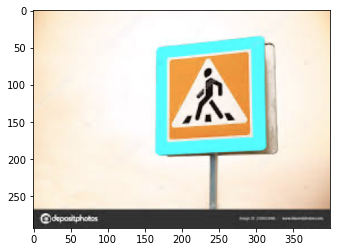

In [8]:
im = cv2.imread(str(df_train.values[58][0]))
bb = create_bb_array(df_train.values[58])
# print(im.shape)

Y = create_mask(bb, im)
mask_to_bb(Y)      

plt.imshow(im)

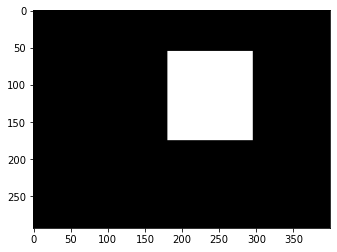

In [9]:
plt.imshow(Y, cmap='gray')

Data argumentation

In [10]:

def crop(im, r, c, target_r, target_c): 
    return im[r:r+target_r, c:c+target_c]

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)

def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT):
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M, (c, r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im, M, (c, r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS)

def random_cropXY(x, Y, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix * c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2 * rand_r * r_pix).astype(int)
    start_c = np.floor(2 * rand_c * c_pix).astype(int)
    xx = crop(x, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    YY = crop(Y, start_r, start_c, r - 2*r_pix, c - 2*c_pix)
    return xx, YY

def transformsXY(path, bb, is_transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB) / 255
    Y = create_mask(bb, x)
    if is_transforms:
        rdeg = (np.random.random()-.50) * 20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, mask_to_bb(Y)

def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

images_resized\road152.png


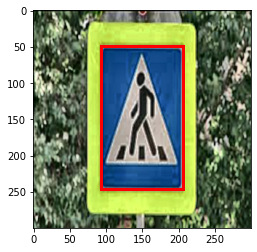

In [11]:
number = 60
im = cv2.imread(str(df_train['new_path'].values[number]))
print(str(df_train.values[number][8]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
show_corner_bb(im, df_train['new_bb'].values[number])

C:\Users\AxBam\AppData\Local\Temp/ipykernel_12916/4048147079.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


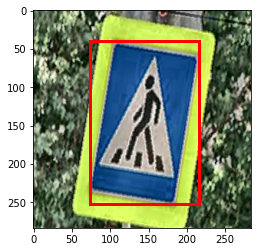

In [12]:
im, bb = transformsXY(str(df_train['new_path'].values[number]),
                      df_train['new_bb'].values[number],
                      is_transforms=True)
show_corner_bb(im, bb)

Pretrain and add 2 layer for classification and regression bounding box

In [13]:
df_train = df_train.reset_index()
X = df_train[['new_path', 'new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)


def normalize(im):
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0]) / imagenet_stats[1]


class RoadDataset(Dataset):
    def __init__(self, paths, bb, y, is_transforms=False):
        self.is_transforms = is_transforms
        self.paths = paths.values
        self.bb = bb.values
        self.y = y.values
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, idx):
        path = self.paths[idx]
        y_class = self.y[idx]
        x, y_bb = transformsXY(path, self.bb[idx], self.is_transforms)
        x = normalize(x)
        x = np.rollaxis(x, 2)
        return x, y_class, y_bb

    
train_ds = RoadDataset(X_train['new_path'], X_train['new_bb'], y_train, is_transforms=True)
valid_ds = RoadDataset(X_val['new_path'], X_val['new_bb'], y_val)

In [14]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [15]:
class BB_model(nn.Module):
    def __init__(self):
        super(BB_model, self).__init__()
        resnet = models.resnet34(pretrained=True)
        layers = list(resnet.children())[:8]
        self.features = nn.Sequential(*layers)
        self.classifier = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        self.bb = nn.Sequential(nn.BatchNorm1d(512), nn.Linear(512, 4))
        
    def forward(self, x):
        x = self.features(x)
        x = F.relu(x)
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1)
        return self.classifier(x), self.bb(x)

In [16]:
resnet = models.resnet34(pretrained=True)
list(resnet.children())[:8]

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   )
   (1): BasicBlock(
     (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), pad

In [17]:
torch.cuda.is_available()

True

In [18]:
model = BB_model().cuda()
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.006)
epochs = 100
model

BB_model(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [19]:
def train():
    val_acc_avg = 0
    for i in range(epochs):

        model.train()
        total = 0
        sum_loss = 0

        for x, y_class, y_bb in train_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            
            loss = loss_class + loss_bb
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            total += len_batch
            sum_loss += loss.item()
        
        train_loss = sum_loss / total

        model.eval()
        val_total = 0
        val_sum_loss = 0
        correct = 0

        for x, y_class, y_bb in valid_dl:
            len_batch = y_class.shape[0]
            x = x.cuda().float()
            y_class = y_class.cuda()
            y_bb = y_bb.cuda().float()
            
            out_class, out_bb = model(x)
            
            loss_class = F.cross_entropy(out_class, y_class, reduction="sum")
            loss_bb = F.l1_loss(out_bb, y_bb, reduction="sum")
            loss = loss_class + loss_bb
            
            _, pred = torch.max(out_class, 1)
            correct += (pred == y_class).sum().item()
            
            val_sum_loss += loss.item()
            val_total += len_batch
            
        val_loss = val_sum_loss / val_total
        val_acc = correct / val_total

        print(f"Epoch [{i+1}/{epochs}]. train_loss {train_loss:.3f} val_loss {val_loss:.3f} val_acc {val_acc:.3f}")
        val_acc_avg = val_acc_avg + val_acc
    val_acc_avg = val_acc_avg / epochs
    print("val_acc_avg = "+str(val_acc_avg))
        

In [20]:
train()

C:\Users\AxBam\AppData\Local\Temp/ipykernel_12916/4048147079.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


Epoch [1/100]. train_loss 543.349 val_loss 51057.583 val_acc 0.125
Epoch [2/100]. train_loss 461.197 val_loss 938.340 val_acc 0.676
Epoch [3/100]. train_loss 275.042 val_loss 203.344 val_acc 0.676
Epoch [4/100]. train_loss 149.444 val_loss 279.927 val_acc 0.614
Epoch [5/100]. train_loss 140.781 val_loss 167.103 val_acc 0.699
Epoch [6/100]. train_loss 139.574 val_loss 149.701 val_acc 0.477
Epoch [7/100]. train_loss 137.091 val_loss 232.217 val_acc 0.426
Epoch [8/100]. train_loss 134.999 val_loss 135.348 val_acc 0.665
Epoch [9/100]. train_loss 130.271 val_loss 133.139 val_acc 0.716
Epoch [10/100]. train_loss 126.169 val_loss 137.528 val_acc 0.625
Epoch [11/100]. train_loss 125.643 val_loss 136.563 val_acc 0.653
Epoch [12/100]. train_loss 120.619 val_loss 125.288 val_acc 0.705
Epoch [13/100]. train_loss 113.146 val_loss 117.822 val_acc 0.682
Epoch [14/100]. train_loss 106.141 val_loss 106.778 val_acc 0.682
Epoch [15/100]. train_loss 97.509 val_loss 104.749 val_acc 0.710
Epoch [16/100]. tr

In [21]:
for i, param_group in enumerate(optimizer.param_groups):
    param_group["lr"] = 0.001

In [22]:
train()

C:\Users\AxBam\AppData\Local\Temp/ipykernel_12916/4048147079.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


Epoch [1/100]. train_loss 43.791 val_loss 62.099 val_acc 0.778
Epoch [2/100]. train_loss 40.476 val_loss 60.780 val_acc 0.807
Epoch [3/100]. train_loss 38.333 val_loss 56.124 val_acc 0.807
Epoch [4/100]. train_loss 36.579 val_loss 60.455 val_acc 0.812
Epoch [5/100]. train_loss 35.773 val_loss 58.623 val_acc 0.795
Epoch [6/100]. train_loss 36.012 val_loss 58.338 val_acc 0.812
Epoch [7/100]. train_loss 35.607 val_loss 56.311 val_acc 0.778
Epoch [8/100]. train_loss 35.281 val_loss 57.142 val_acc 0.790
Epoch [9/100]. train_loss 36.144 val_loss 57.230 val_acc 0.784
Epoch [10/100]. train_loss 34.994 val_loss 56.618 val_acc 0.795
Epoch [11/100]. train_loss 36.697 val_loss 57.846 val_acc 0.790
Epoch [12/100]. train_loss 35.633 val_loss 57.744 val_acc 0.824
Epoch [13/100]. train_loss 35.990 val_loss 55.959 val_acc 0.812
Epoch [14/100]. train_loss 38.679 val_loss 56.938 val_acc 0.795
Epoch [15/100]. train_loss 39.024 val_loss 55.848 val_acc 0.801
Epoch [16/100]. train_loss 33.710 val_loss 55.789

Save model to file 'roadSignDetection.pkl'

In [ ]:
import joblib
joblib.dump(model,'roadSignDetection.pkl')

In [23]:

model = joblib.load('roadSignDetection.pkl')
im = read_image('./images_resized/road869.png')
Path.mkdir(Path('./road_signs_test'), exist_ok=True)
cv2.imwrite('./road_signs_test/road869.jpg', cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

True

Test with unseen data

In [24]:
# test Dataset
test_ds = RoadDataset(
    pd.DataFrame([{'path':'./road_signs_test/road869.jpg'}])['path'],
    pd.DataFrame([{'bb':np.array([0,0,0,0])}])['bb'],
    pd.DataFrame([{'y':[0]}])['y']
)
x, y_class, y_bb = test_ds[0]

xx = torch.FloatTensor(x[None,])
xx.shape

C:\Users\AxBam\AppData\Local\Temp/ipykernel_12916/4048147079.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  bb = bb.astype(np.int)


torch.Size([1, 3, 284, 284])

In [25]:
out_class, out_bb = model(xx.cuda())
out_class, out_bb

(tensor([[ 8.2451, -3.7740,  2.1336, -9.5811]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([[ 75.6983,  72.2825, 144.9070, 160.6363]], device='cuda:0',
        grad_fn=<AddmmBackward0>))

Predicted class

In [26]:

torch.max(out_class, 1)

torch.return_types.max(
values=tensor([8.2451], device='cuda:0', grad_fn=<MaxBackward0>),
indices=tensor([0], device='cuda:0'))

In [27]:
class_dict

{'speedlimit': 0, 'stop': 1, 'crosswalk': 2, 'trafficlight': 3}

Predicted bounding box

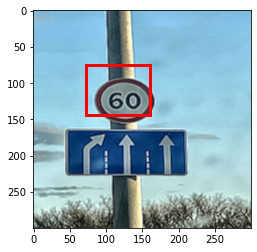

In [28]:

bb_hat = out_bb.detach().cpu().numpy()
bb_hat = bb_hat.astype(int)
show_corner_bb(im, bb_hat[0])